<a href="https://colab.research.google.com/github/M-Rasit/Demand-Prediction-with-Bidirectional-LSTM/blob/main/Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to ***Demand Prediction Project***. 

As you know recently, free or affordable access to bicycles has been provided for short-distance trips in an urban area as an alternative to motorized public transport or private vehicles. Thus, it is aimed to reduce traffic congestion, noise and air pollution.

In this project, the goal is to predict the number of future bike shares given the historical data of London bike shares. So this case should be handled as a time series problem with ***Bidirectional LSTM***. 

---

# Determines



#### Features

- timestamp - timestamp field for grouping the data
- cnt - the count of a new bike shares
- t1 - real temperature in C
- t2 - temperature in C “feels like”
- hum - humidity in percentage
- wind_speed - wind speed in km/h
- weather_code - category of the weather
- is_holiday - boolean field - 1 holiday / 0 non holiday
- is_weekend - boolean field - 1 if the day is weekend
- season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

---

## 1. Exploratory Data Analysis

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Missing Values and Outliers

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Demand Prediction Task/store_sharing.csv", index_col=0, parse_dates=True)
df.head(5)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [ ]:
df.shape

(17414, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [ ]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [ ]:
df.isnull().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [ ]:
def outlier_detection(df, column, z_threshold=3):
    
    """ This function determines skewness and curtosis. It plots histogram and boxplot.
    Also it stores index of outliers according to threshold value."""

    print("Skewness:", stats.skew(df[column]))
    print("Kurtosis:", stats.kurtosis(df[column]))
    print("\n\n\n")

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    
    ax[0].set_title(f"Histogram of {column} Column", c="blue", size=14)
    sns.histplot(df[column], ax=ax[0], palette="Blues")
    
    ax[1].set_title(f"Boxplot of {column} Column", c="blue", size=14)
    sns.boxplot(df[column], ax=ax[1], palette="Blues")
    plt.show()
    
    z_score = np.abs(stats.zscore(df[column]))
    outliers = np.where(z_score > z_threshold) 
    
    return outliers[0]

Skewness: 1.3255926061562282
Kurtosis: 1.5438447380215816






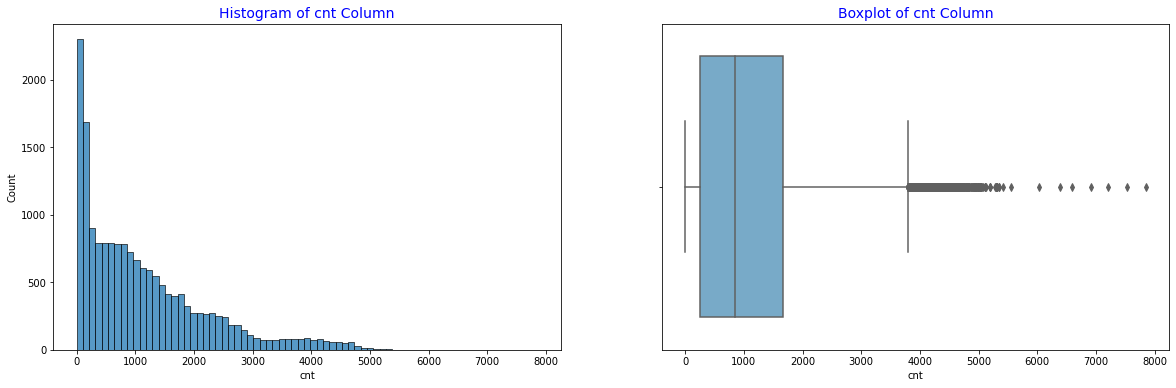

In [ ]:
# cnt column
cnt_outliers = outlier_detection(df, "cnt")

Skewness: 0.20384480445558084
Kurtosis: -0.26194859084551725






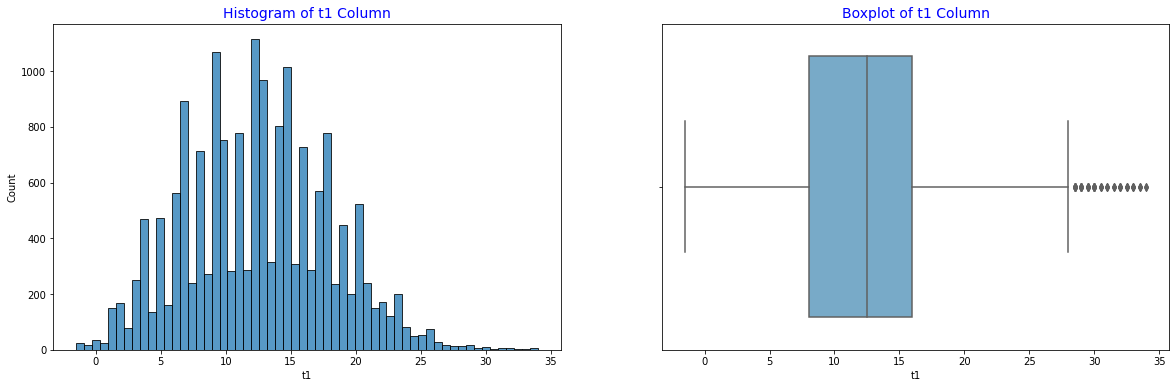

In [ ]:
# t1 column

t1_outliers = outlier_detection(df, "t1")

Skewness: -0.058347170427313154
Kurtosis: -0.6600590175875585






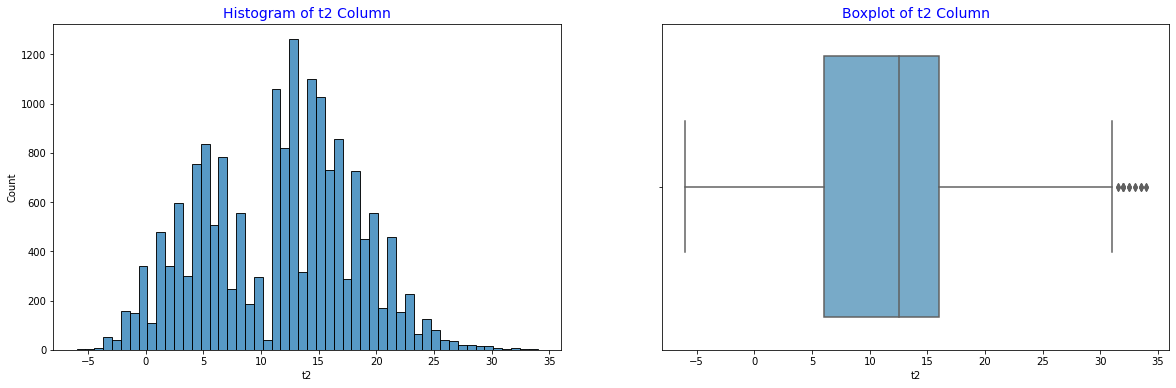

In [ ]:
# t2 column

t2_outliers = outlier_detection(df, "t2")

Skewness: -0.5727325819296263
Kurtosis: -0.25603623137838794






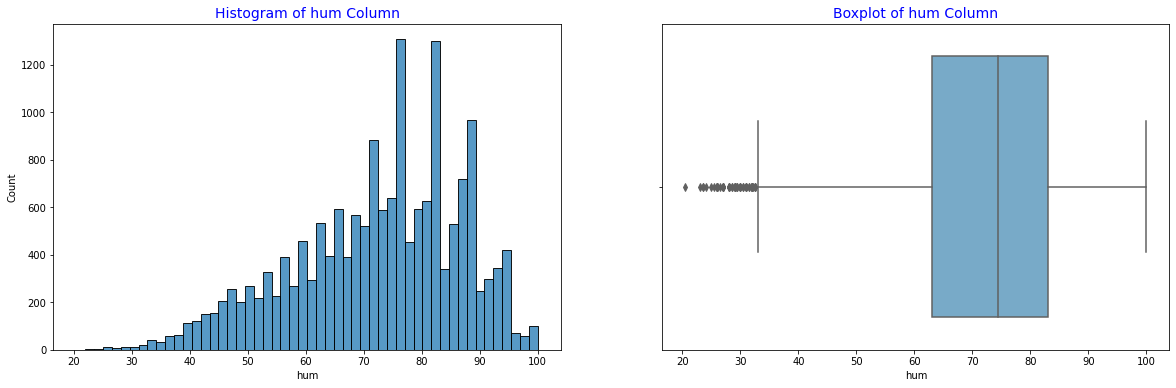

In [ ]:
# hum column

hum_outliers = outlier_detection(df, "hum")

Skewness: 0.6689536263053214
Kurtosis: 0.4487624716273553






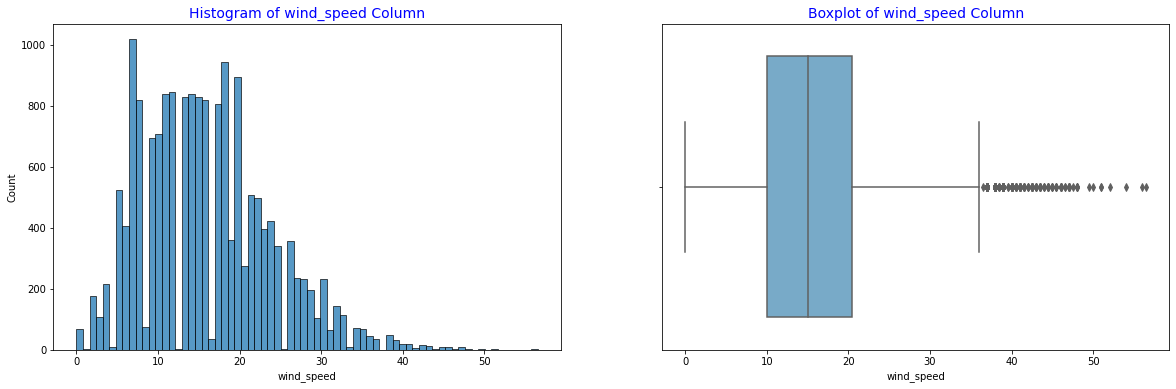

In [ ]:
# wind_speed column

wind_outliers = outlier_detection(df, "wind_speed")

Skewness: 4.027209588295398
Kurtosis: 32.232737013355624






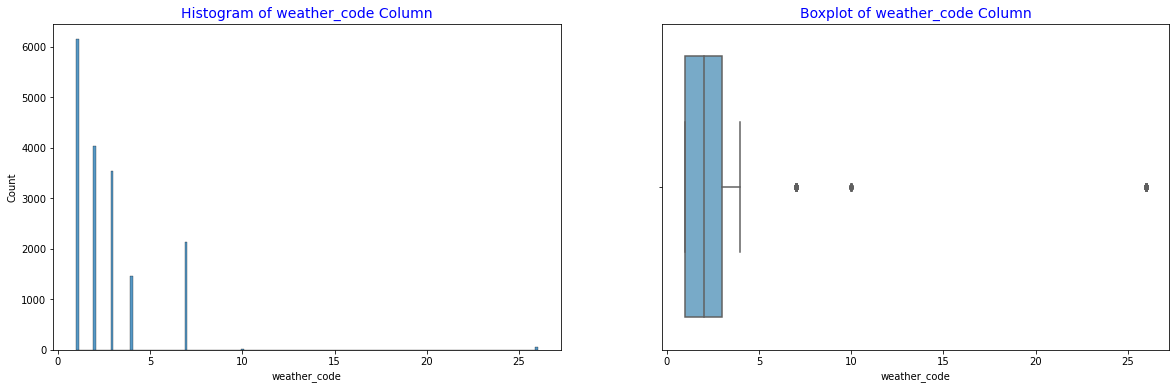

In [ ]:
# weather_code column

weather_outliers = outlier_detection(df, "weather_code")

### Plot Breakdowns of Data

***i. Plot bike shares over time***

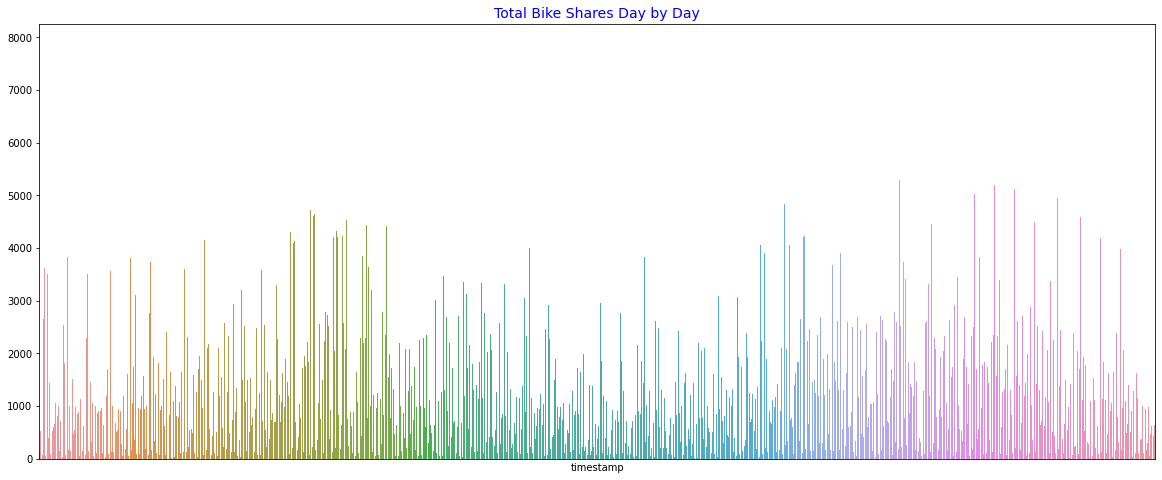

In [ ]:
# Extracting meaningful values from timestamp index

df["month"] = df.index.month
df["day_of_month"] = df.index.day
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek

# Barplot day by day 

plt.figure(figsize=(20,8))
plt.title("Total Bike Shares Day by Day", c="blue", size=14)
sns.barplot(x=df.index, y=df["cnt"].values)

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

***ii. Plot bike shares by months***

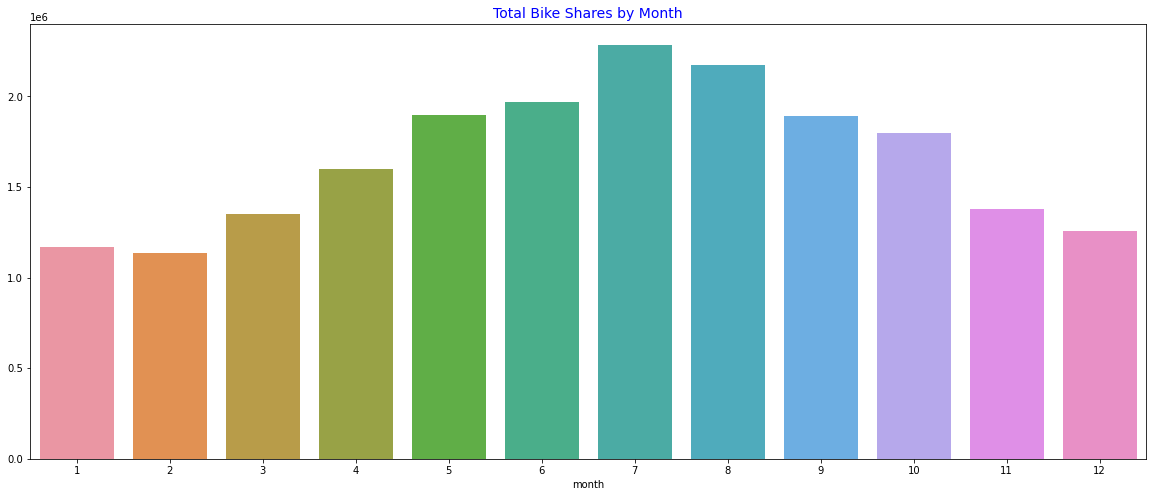

In [ ]:
total_cnt_by_month = df.groupby("month")["cnt"].sum()

plt.figure(figsize=(20,8))
plt.title("Total Bike Shares by Month", c="blue", size=14)
sns.barplot(x = total_cnt_by_month.keys(), y=total_cnt_by_month.values)

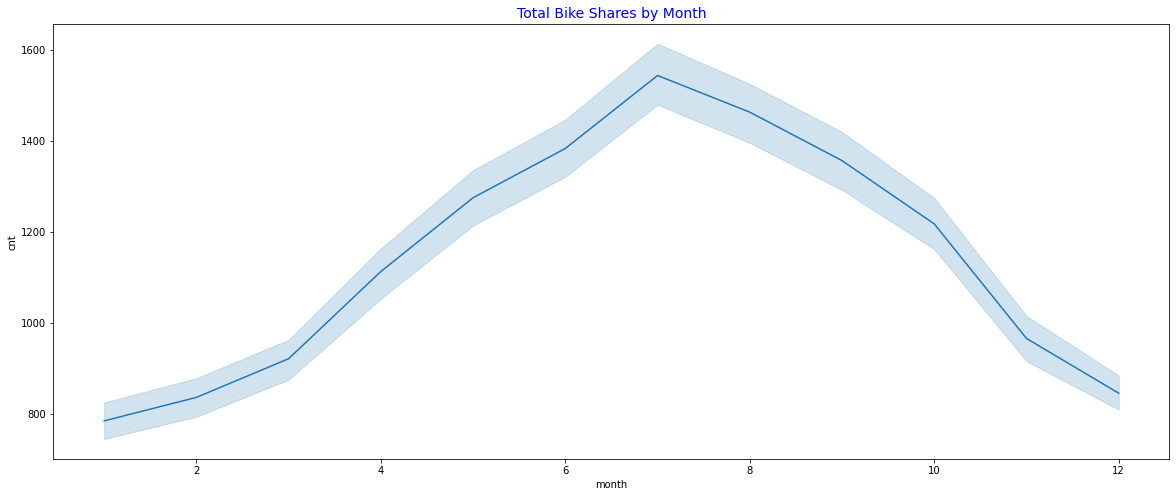

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Total Bike Shares by Month", c="blue", size=14)
sns.lineplot(data=df, x="month", y="cnt")

***iii. Plot bike shares by hours***

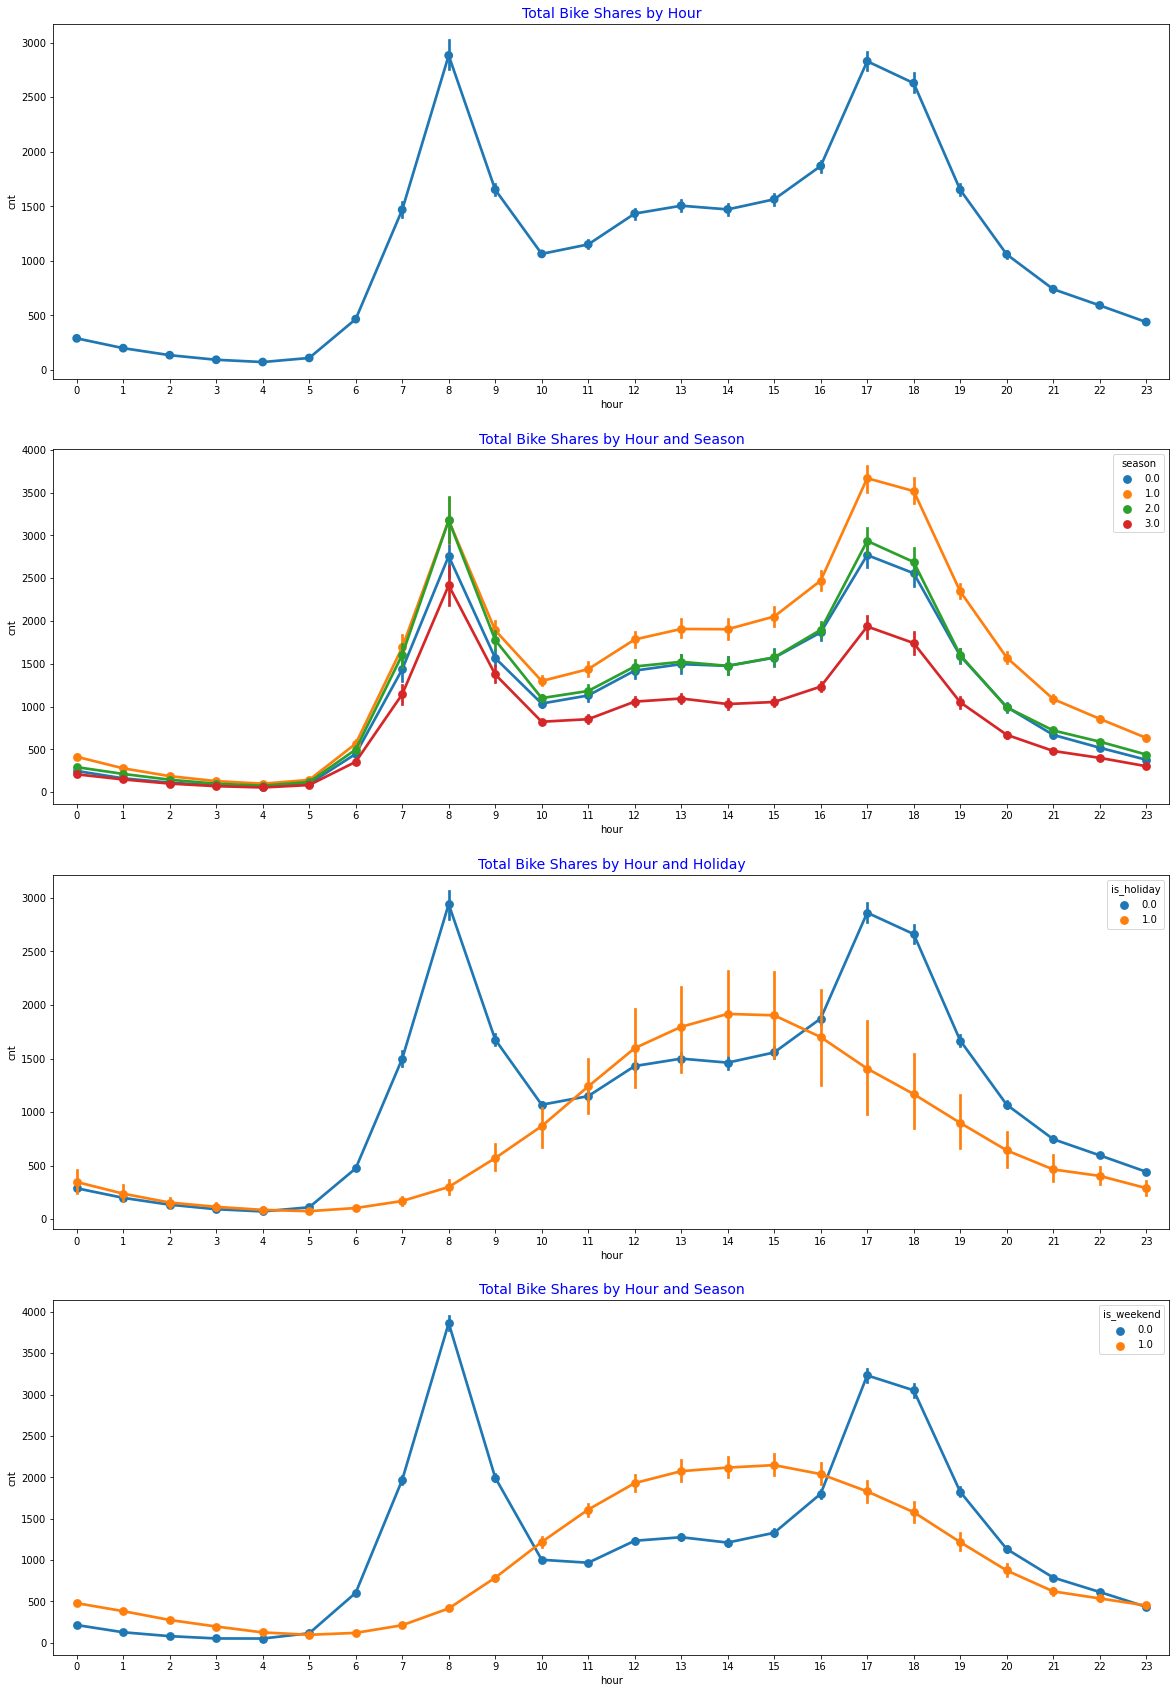

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 30))

ax[0].set_title("Total Bike Shares by Hour", c="blue", size=14)
sns.pointplot(data=df, x='hour', y='cnt', ax=ax[0])

ax[1].set_title("Total Bike Shares by Hour and Season", c="blue", size=14)
sns.pointplot(data=df, x='hour', y='cnt', hue="season", ax=ax[1])

ax[2].set_title("Total Bike Shares by Hour and Holiday", c="blue", size=14)
sns.pointplot(data=df, x='hour', y='cnt', hue="is_holiday", ax=ax[2])

ax[3].set_title("Total Bike Shares by Hour and Season", c="blue", size=14)
sns.pointplot(data=df, x='hour', y='cnt', hue="is_weekend", ax=ax[3])

***iv. Plot bike shares by day of week***

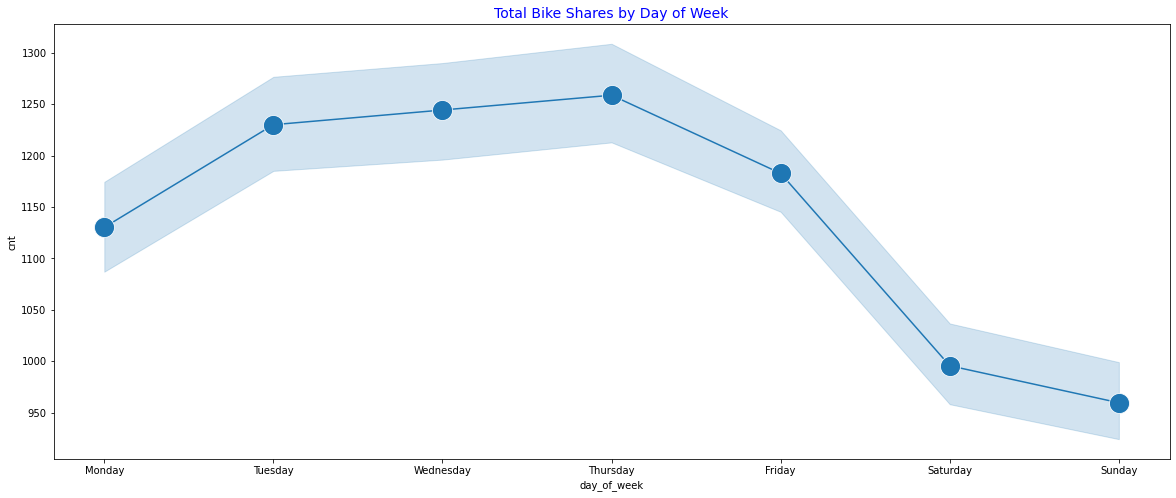

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Total Bike Shares by Day of Week", c="blue", size=14)
labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax = plt.gca()
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(labels)
sns.lineplot(data=df, x='day_of_week', y='cnt', marker="o", markersize=20)

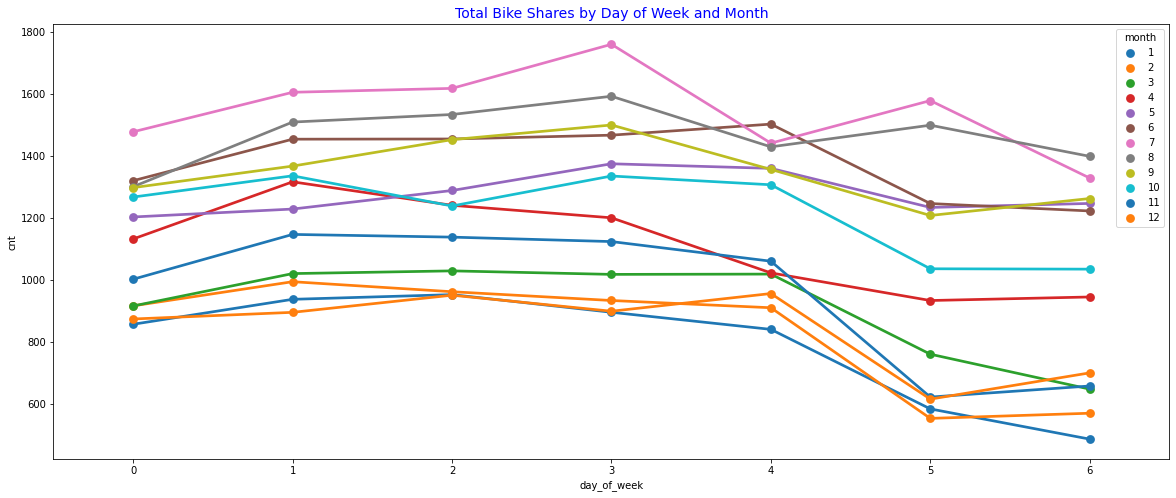

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Total Bike Shares by Day of Week and Month", c="blue", size=14)
labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax = plt.gca()
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(labels)
sns.pointplot(data=df, x='day_of_week', y='cnt', marker="o", hue="month", markersize=20, palette="tab10", ci=0)

***v. Plot the distribution of bike shares on holidays by seasons***

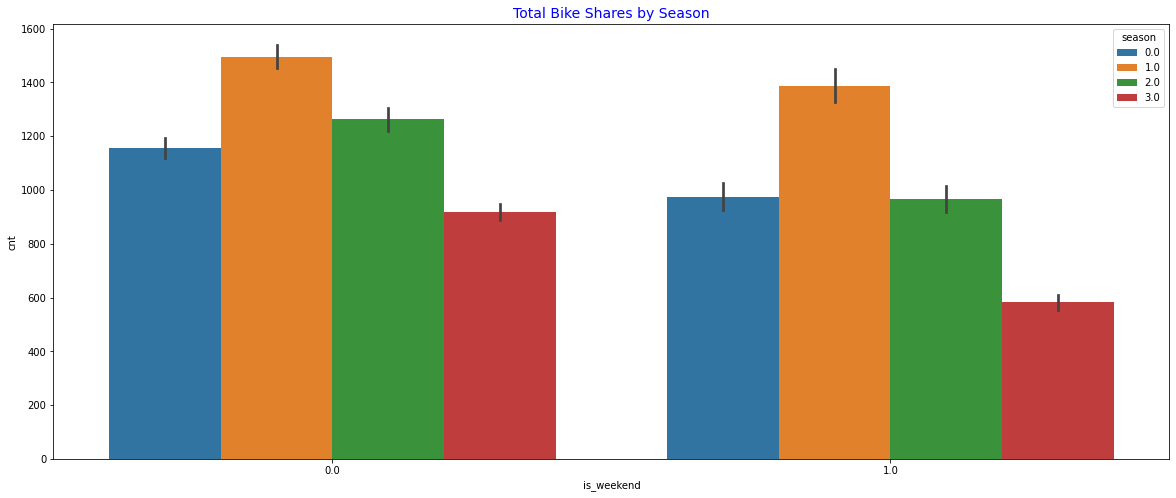

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Total Bike Shares by Season", c="blue", size=14)
sns.barplot(data=df, x = "is_weekend", y="cnt", hue="season")

---

## 2. Data Pre-Processing


### Train - Test Split

Appropriately split the data for optimum training.

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train , test = df.iloc[:train_size], df.iloc[train_size:]

### Scaling

**Robust Scaling**

It is common to scale data prior to fitting a machine learning model.

This is because data often consists of many different input variables or features (columns) and each may have a different range of values or units of measure, such as feet, miles, kilograms, dollars, etc.

If there are input variables that have very large values relative to the other input variables, these large values can dominate or skew some machine learning algorithms. The result is that the algorithms pay most of their attention to the large values and ignore the variables with smaller values.

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used.

In [ ]:
cols = ['t1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday',
       'is_weekend', 'season', 'month', 'day_of_month', 'hour', 'day_of_week']

df_scaler = RobustScaler()
target_scaler = RobustScaler()

train.loc[:, cols] = df_scaler.fit_transform(train[cols].to_numpy())
train["cnt"] = target_scaler.fit_transform(train[["cnt"]])

test.loc[:, cols] = df_scaler.transform(test[cols].to_numpy())
test["cnt"] = target_scaler.transform(test[["cnt"]])

### Define a Function for Creating Time Steps 

In order to use the capabilities of LSTM, we need to organize the data in accordance with the working principles of LSTM.

In [ ]:
def create_dataset(dataset, target, step=1):
    X, Y = [], []
    for i in range(len(dataset)-step-1):
        v = dataset.iloc[i:(i+step), :].values
        X.append(v)
        Y.append(dataset[target].iloc[i + step])
    return np.array(X), np.array(Y)

In [ ]:
step = 30
target_column = "cnt"

X_train, Y_train = create_dataset(train, target_column, step)
X_test, Y_test = create_dataset(test, target_column, step)

---

## 3. Model Building with LSTM



Recurrent Neural Networks 
RNN are a type of artifcial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, the spoken word, numerical times series data.

Recurrent Neural Networks use backpropagation algorithm for training. Because of their internal memory, RNN’s are able to remember important things about the input they received, which enables them to be very precise in predicting what’s coming next.

RNNs could be stacked up to deeper versions, which contain more than 1 layers of RNN. Because RNNs are especially computationally expensive to train, normally a deep RNN model contains no more than 3 layers of LSTM.

Train a bidirectional long short term memory (LSTM) recurrent neural network (RNN) with this data, making use of the self-loop and forget gate of LSTM.

LSTM sequential learning model was chosen because of its ability to process sequential data and memorize data of past time steps.

LSTM is a different type of gated RNN which is capable of learning long-term dependencies LSTM is not affected by vanishing gradient or exploding gradient problem
Using Bidirectional LSTMs, we feed the learning algorithm with the original data once from beginning to the end and once from end to beginning.

#### Bidirectional LSTM :
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem. Figure shows the mechanism of Bidirectional LSTM.






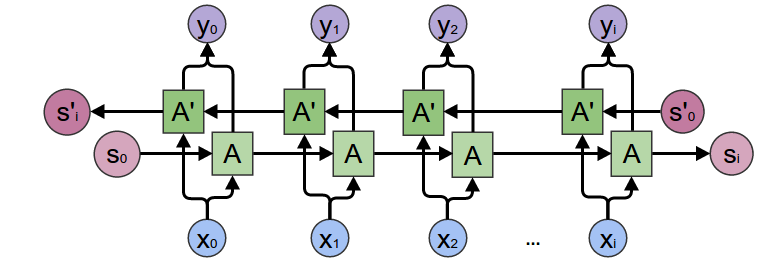

### Create, Compile and Fit Bidirectional LSTM Model

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2] - 1))))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(optimizer="Adam", loss="mean_squared_error")

In [ ]:
early_stop = EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(X_train, Y_train, batch_size=64, epochs=200, validation_split=0.1, callbacks=early_stop)

Epoch 1/200
196/196 [==============================] - 19s 78ms/step - loss: 0.3021 - val_loss: 0.1211
Epoch 2/200
196/196 [==============================] - 15s 75ms/step - loss: 0.0933 - val_loss: 0.0623
Epoch 3/200
196/196 [==============================] - 15s 75ms/step - loss: 0.0573 - val_loss: 0.0515
Epoch 4/200
196/196 [==============================] - 15s 76ms/step - loss: 0.0472 - val_loss: 0.0451
Epoch 5/200
196/196 [==============================] - 15s 75ms/step - loss: 0.0386 - val_loss: 0.0448
Epoch 6/200
196/196 [==============================] - 15s 75ms/step - loss: 0.0349 - val_loss: 0.0366
Epoch 7/200
196/196 [==============================] - 15s 75ms/step - loss: 0.0325 - val_loss: 0.0368
Epoch 8/200
196/196 [==============================] - 15s 76ms/step - loss: 0.0318 - val_loss: 0.0344
Epoch 9/200
196/196 [==============================] - 15s 75ms/step - loss: 0.0284 - val_loss: 0.0328
Epoch 10/200
196/196 [==============================] - 15s 76ms/step - l

### Plot Train and Validation Losses

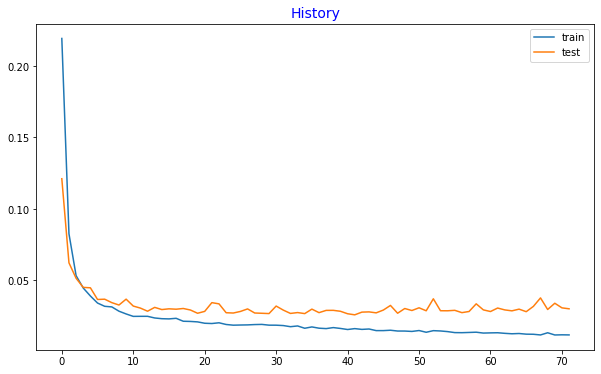

In [ ]:
plt.figure(figsize=(10,6))
plt.title("History", c="blue", size=14)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend();

---

## 4. Demand Predictions

At this stage, you we measure the prediction success of your model. So, you will need to compare the actual values of the test data with their predicted values. 

For this reason, you must inverse transform the y_pred variable predicted by the model with the target variables of the train and test data you have previously scaled.

### Inverse Transform

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = target_scaler.inverse_transform(Y_train.reshape(-1,1))
y_test_inv = target_scaler.inverse_transform(Y_test.reshape(-1,1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

### Plot Prediction

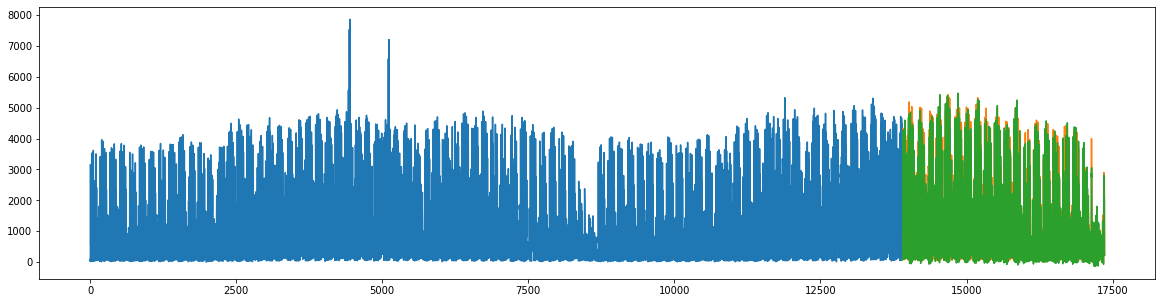

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0, len(Y_train)), y_train_inv.flatten())
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), y_test_inv.flatten())
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), y_pred_inv.flatten())

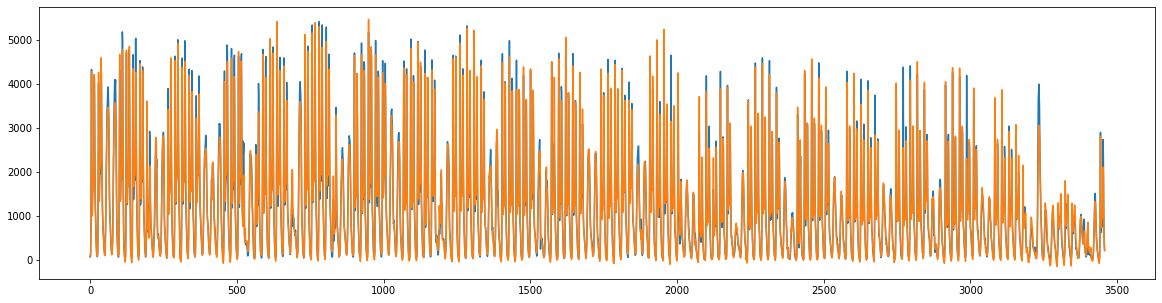

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(y_test_inv)), y_test_inv.flatten())
plt.plot(np.arange(len(y_test_inv)), y_pred_inv.flatten())

### Calculate Train and Test Error Scores

In [ ]:
def eval_metrics(test, pred):

  print("Mean Absolute Error:", mean_absolute_error(test, pred))
  print("Mean Squared Error:", mean_squared_error(test, pred))
  print("Root Mean Squared Error:", math.sqrt(mean_squared_error(test, pred)))
  print("Explained Variance Score:", explained_variance_score(test, pred))

In [ ]:
eval_metrics(y_test_inv, y_pred_inv)

Mean Absolute Error: 111.931012649492
Mean Squared Error: 34893.22831899036
Root Mean Squared Error: 186.7972920547575
Explained Variance Score: 0.972645380778952
